# Travelling Salesman - Genetic Algorithm

In [1]:
# importing libraries
import math
import random
from matplotlib import pyplot as plt


class Map:
    def __init__(self, coordinates):
        self.coordinates = coordinates
        self.distance_matrix = self.populate_distance_matrix(coordinates)

    def plot(self):
        x, y = zip(*self.coordinates)
        plt.scatter(x, y, c="r")
        plt.show()

    def calculate_hypotenuse(self, coordinates, a, b):
        x1, y1 = coordinates[a]
        x2, y2 = coordinates[b]
        return math.sqrt( abs(x1-x2)**2 + abs(y1-y2) )

    def populate_distance_matrix(self, coordinates):
        l = len(coordinates)
        dist_matrix = [[0 for j in range(l)] for i in range(l)]
        for i in range(l):
            for j in range(i, l):
                dist_matrix[i][j] = self.calculate_hypotenuse(coordinates, i, j)
                dist_matrix[j][i] = dist_matrix[i][j]
        return dist_matrix


class Route:
    def __init__(self, map, path):
        self.map = map
        self.path = path
        self.distance = self.calculate_distance(map, path)
        # fitness used in Genetic Algorithm
        self.fitness = 0

    def update_path(self, new_path):
        self.path = new_path
        self.distance = self.calculate_distance(self.map, self.path)

    def calculate_distance(self, map, path):
        l = len(path)
        total = 0
        for i in range(l):
            total += map.distance_matrix[path[i]][path[(i+1)%l]]
        return total

    def plot(self):
        r = [self.map.coordinates[self.path[-1]]]
        for n in self.path:
            r.append(self.map.coordinates[n])
        x, y = zip(*r)
        plt.scatter(x, y, c="r")
        plt.plot(x, y)
        plt.suptitle(f"Distance = {self.distance}")
        plt.show()

    def __repr__(self):
        return f"Number of nodes = {len(self.path)}, distance = {self.distance}."


# function generating a random initial path
def create_initial_random(map):
    indices = list(range(len(map.coordinates)))
    random.shuffle(indices)
    return indices

# function generating the initial path using greedy algorithm
# always choosing the closest unvisited node
def create_initial_greedy(map, start=None):
    if start is None:
        path = [random.randrange(len(map.coordinates))]
    else:
        path = [start]
    while len(path) < len(map.coordinates):
        current = path[-1]
        indices = [ind for ind in range(len(map.coordinates)) if ind not in path]
        smallest = float("inf")
        next = -1
        for ind in indices:
            if map.distance_matrix[current][ind] < smallest:
                smallest = map.distance_matrix[current][ind]
                next = ind
        path.append(next)
    return path

def calc_fitness(population):
    total_fitness = max([1/i.distance for i in population])
    # this fitness function compares the distance to the best distance achieved (100%) and ^4 the result, to ensure greater variety in fitness scores
    for i in population:
        i.fitness = ((1/i.distance)/total_fitness)**4
    population.sort(key=lambda i: i.fitness, reverse=True)
    return population

# function for creating initial populations
def create_population(map, popsize, random=True):
    population = list()
    if random == True:
        for i in range(popsize):
            population.append(Route(map, create_initial_random(map)))
    else:
        for i in range(popsize):
            population.append(Route(map, create_initial_greedy(map)))
    return calc_fitness(population)

def selection(population):
    # 10% elite that gets selected automatically
    elite = int(len(population)/10)
    selected = population[:elite]
    while len(selected) < len(population):
        i = random.choice(population)
        if i.fitness > random.random():
            selected.append(i)
    selected = calc_fitness(selected)
    # shuffling the routes, to enable random crossover
    random.shuffle(selected)
    return selected

def crossover(population):
    children = []
    for i in range(0, len(population)):
        parent1_path = population[i].path
        parent2_path = population[(i+1)%len(population)].path
        a = random.randrange(len(parent1_path))
        b = random.randrange(len(parent1_path))
        # # uncomment below to crossover every time
        # start = min(a, b)
        # stop = max(a, b) + 1
        child_path = parent1_path[a:b] # parent1_path[start:stop]
        for node in parent2_path:
            if node not in child_path:
                child_path.append(node)
        children.append(Route(population[i].map, child_path))
    return calc_fitness(children)

# # crossover every time keeping 50% of nodes from on parent
# def crossover(population):
#     children = []
#     for i in range(0, len(population)):
#         parent1_path = population[i].path
#         parent2_path = population[(i+1)%len(population)].path
#         split = int(len(parent1_path)/2)
#         child_path = parent1_path[:split]
#         for node in parent2_path:
#             if node not in child_path:
#                 child_path.append(node)
#         children.append(Route(population[i].map, child_path))
#     return calc_fitness(children)

# function that swaps two random nodes
def node_swapper(path):
    p = list(path)
    index1 = random.randrange(0, len(p))
    index2 = index1
    while index2 == index1:
        index2 = random.randrange(0, len(p))
    temp = p[index2]
    p[index2] = p[index1]
    p[index1] = temp
    return p

def mutation(population):
    for i in population:
        #the chance of mutation increases in less fit specimen
        if random.random() > i.fitness:
            i.update_path(node_swapper(i.path))
    return calc_fitness(population)


def run_genetic_algorithm(map, popsize, max_no_improv):
    distances = []
    starting_population = create_population(map, popsize)
    print("Running Genetic Algorithm")
    print("Best initial random route:")
    starting_population[0].plot()
    no_improvement_for = 0
    while no_improvement_for < max_no_improv:
        distances.append(starting_population[0].distance)
        select = selection(starting_population)
        children = crossover(select)
        starting_population = mutation(children)
        if starting_population[0].distance >= distances[-1]:
            no_improvement_for += 1
        else:
            no_improvement_for = 0
    print(f"Best route after {len(distances)} iterations:")
    starting_population[0].plot()
    plt.figure(figsize=(6, 5))
    plt.subplots_adjust(top=0.8)
    plt.plot(distances)
    plt.suptitle(f"Number of nodes = {len(starting_population[0].path)}\nPopulation size = {popsize}\nStarting distance = {distances[0]}\nFinal Distance = {distances[-1]}")
    plt.show()

### A map of 24 nodes

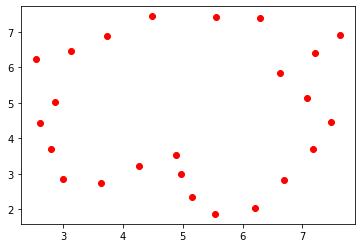

In [2]:
# converting the input matrix into a 2d list
with open("TSP Matrix3.csv") as input:
    map24_coordinates = [tuple([float(n) for n in line.split(",")]) for line in input.read().splitlines()]

map24 = Map(map24_coordinates)
map24.plot()

Running Genetic Algorithm
Best initial random route:


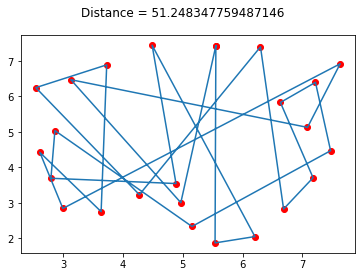

Best route after 371 iterations:


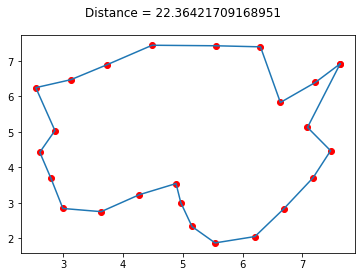

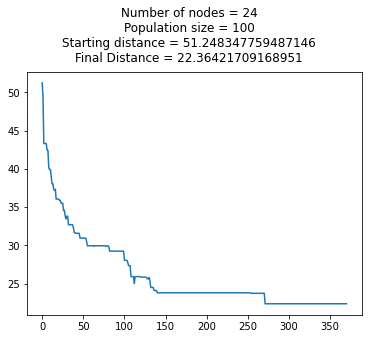

In [7]:
run_genetic_algorithm(map24, 100, 100)

### A random map of 100 nodes

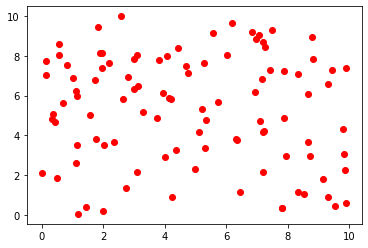

In [4]:
map100_coordinates = []

for i in range(100):
    a = round(random.uniform(0, 10), 3)
    b = round(random.uniform(0, 10), 3)
    map100_coordinates.append((a, b))
    
map100 = Map(map100_coordinates)
map100.plot()

Running Genetic Algorithm
Best initial random route:


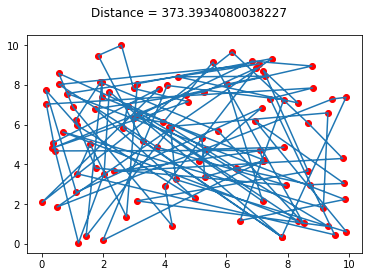

Best route after 1061 iterations:


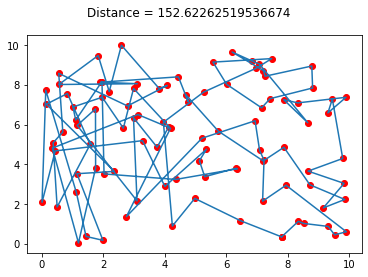

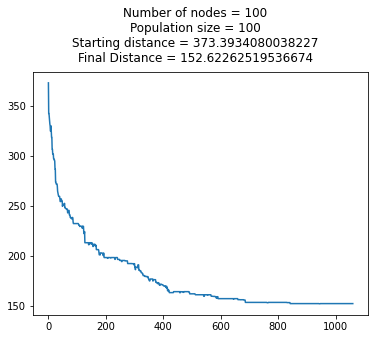

In [5]:
run_genetic_algorithm(map100, 100, 100)